In [ ]:
# Circle Finder CNN - Colab Compatible

In [ ]:
## 1. Install Required Packages
!pip install shapely scikit-image

In [1]:
## 2. Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
## 3. Dataset Class
class CircleDataset(Dataset):
    def __init__(self, data_path):
        self.files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.json')]
        self.transform = transforms.ToTensor()
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        with open(self.files[idx], 'r') as f:
            data = json.load(f)
        img = np.array(data['img'], dtype=np.float32)
        label = data['label']
        img = np.expand_dims(img, axis=0)  # Add channel dimension
        target = torch.tensor([label['row'], label['col'], label['radius']], dtype=torch.float32)
        return torch.tensor(img, dtype=torch.float32), target

In [9]:
## 4. CNN Model
class CircleFinderCNN(nn.Module):
    def __init__(self):
        super(CircleFinderCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 3)  # Output: row, col, radius
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
## 5. Training Function
def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

In [26]:
## 6. Load Data and Train
data_dir = './data'  # Ensure this folder contains your 1000 .json files
full_dataset = CircleDataset(data_dir)
train_idx, val_idx = train_test_split(list(range(len(full_dataset))), test_size=0.2)
train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10)

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CircleFinderCNN()
train_model(model, train_loader, val_loader, device, epochs=10)

Epoch 1, Train Loss: 7230.1929, Val Loss: 4461.9832
Epoch 2, Train Loss: 5171.5364, Val Loss: 4009.2012
Epoch 3, Train Loss: 4594.6466, Val Loss: 4516.2544
Epoch 4, Train Loss: 4062.9711, Val Loss: 3894.7640
Epoch 5, Train Loss: 4612.8798, Val Loss: 4979.9456
Epoch 6, Train Loss: 4681.8024, Val Loss: 4648.3751
Epoch 7, Train Loss: 4060.6938, Val Loss: 4225.5962
Epoch 8, Train Loss: 3991.3298, Val Loss: 3767.5375
Epoch 9, Train Loss: 3475.2243, Val Loss: 4535.4523
Epoch 10, Train Loss: 3982.0420, Val Loss: 4556.6674


In [ ]:
## 7. Evaluate with IoU

In [14]:
%pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
from shapely.geometry import Point

In [29]:
def intersection_over_union(circ1_dict, circ2_dict):
    shape1 = Point(circ1_dict['row'], circ1_dict['col']).buffer(circ1_dict['radius'])
    shape2 = Point(circ2_dict['row'], circ2_dict['col']).buffer(circ2_dict['radius'])
    return shape1.intersection(shape2).area / shape1.union(shape2).area

In [30]:
def evaluate_model(model, dataloader, device, iou_threshold=0.5):
    model.eval()
    matches = 0
    total = 0
    with torch.no_grad():
        for imgs, targets in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs).cpu().numpy()
            targets = targets.numpy()
            for pred, true in zip(outputs, targets):
                pred_dict = {'row': pred[0], 'col': pred[1], 'radius': pred[2]}
                true_dict = {'row': true[0], 'col': true[1], 'radius': true[2]}
                iou = intersection_over_union(pred_dict, true_dict)
                if iou > iou_threshold:
                    matches += 1
                total += 1
    accuracy = matches / total
    print(f"IoU > {iou_threshold} Accuracy: {accuracy:.2%}")
    return accuracy

In [31]:
# Run evaluation
evaluate_model(model, val_loader, device)

IoU > 0.5 Accuracy: 0.00%


0.0

In [ ]:
## 8. Visualize Predictions

In [34]:
def show_predictions(model, dataset, device, num_samples=5):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, idx in enumerate(indices):
        img, true = dataset[idx]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device)).cpu().numpy()[0]
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].add_patch(plt.Circle((true[1], true[0]), true[2], color='lime', fill=False, linewidth=2, label='True'))
        axs[i].add_patch(plt.Circle((pred[1], pred[0]), pred[2], color='red', fill=False, linewidth=2, linestyle='--', label='Pred'))
        axs[i].set_title(f"IoU: {intersection_over_union({'row': true[0].item(), 'col': true[1].item(), 'radius': true[2].item()}, {'row': pred[0], 'col': pred[1], 'radius': pred[2]}):.2f}")
        axs[i].axis('off')
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()

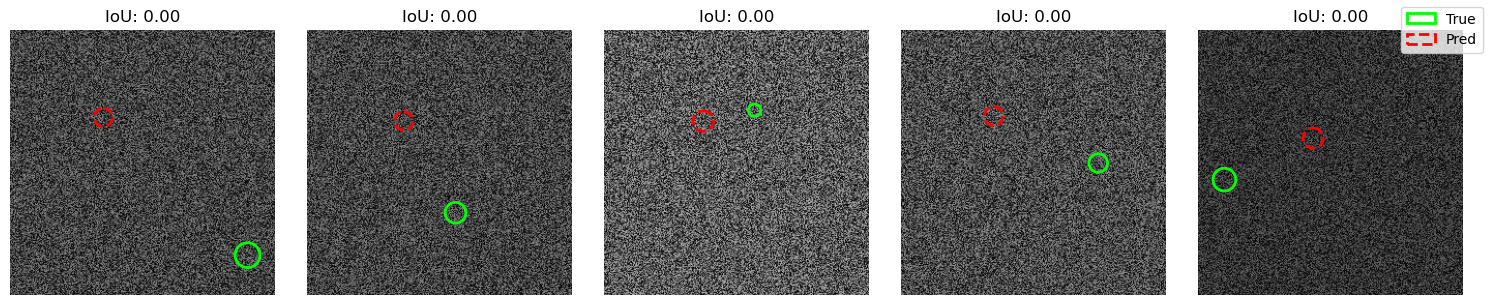

In [35]:
# Show some predictions
show_predictions(model, val_dataset, device, num_samples=5)